#### Master of Data Science (Digital Humanities), Durham University
#### Final Project Notebooks

### DATA40345 Data Science Research Project

#### NLP Esquire: A Data-Driven Analysis and Categorisation of the Judgments of the United Kingdom Supreme Court

## Notebook 3: Binary Classification 

In [1]:
#libraries for data processing, cleaning, manipulation, sampling
import pandas as pd
import numpy as np

from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.utils import resample

#library for training/testing
from sklearn.model_selection import train_test_split
import random

#libraries/packages for implementing traditional classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score

#libraries/packages for implementing deep learning architectures
import torch
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim

#libraries for evaluation metrics of classifiers
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import time
import tqdm

#visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading the dataset with the case ID and the labels
labels = pd.read_csv("UKSC_Labelled_FINAL for ML.csv", names=["title", "label"])
labels.head(10)

#https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

,title,label
0,uksc-2009-0015-judgment-01,human rights
1,uksc-2009-0019-judgment,family
2,uksc-2009-0020-judgment,human rights
3,uksc-2009-0022-judgment,immigration
4,uksc-2009-0031-judgment,family
5,uksc-2009-0032-judgment,tort
6,uksc-2009-0034-judgment,family
7,uksc-2009-0036-judgment,international
8,uksc-2009-0037-judgment,land
9,uksc-2009-0038-judgment,land


In [3]:
#investigating the no.of labels and corresponding samples
counts = labels["label"].value_counts()
counts

criminal                    99
immigration                 98
admin                       95
human rights                76
international               65
tax                         62
labour                      51
contract                    49
land                        47
tort                        46
company                     45
family                      37
insurance                   25
procedure                   20
intellectual property       19
constitutional              19
shipping                     7
mental capacity              6
arbitration                  6
competition                  5
equity                       5
banking                      4
civil                        4
trust                        3
security                     3
damages                      3
public                       2
mental health                2
jurisdiction                 2
contempt                     2
statutory interpretation     1
legal aid                    1
telecom 

In [4]:
#loading the dataset with the case ID and the judgment texts
text = pd.read_csv("UKSC Judgments.csv")
text.head(4)

,title,text
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...


In [5]:
labels.info()
print()
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   label   918 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   text    918 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


Merge the two dataframes on "title" column

In [6]:
#merge on title using merge() method
merge_df = text.merge(labels, on="title")
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   text    918 non-null    object
 2   label   918 non-null    object
dtypes: object(3)
memory usage: 28.7+ KB


In [7]:
merge_df.head(5)

,title,text,label
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,human rights
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,family
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,human rights
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,immigration
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,family


### Preparing a Two-Class Dataset for Binary Classification

There are more than 40 labels. However, these areas can all be classified into broadly two areas of law, as it is classified by legal systems generally: civil and criminal law. 

The following steps were taken to amalgamate specific labels:

1. Fraud was assigned to criminal law as it is a criminal offence.

2. Security was also assigned to criminal law as it deals with national security.

3. Jurisdiction, procedure, international, and contempt were removed from consideration as they could be either criminal or civil depending on the case.

In [8]:
#identify labels to replace
label_replace_civil = ["admin", "human rights", "tax", "labour", "contract", "land", "tort",
                       'company', "family", "insurance", 'intellectual property', 'arbitration', "shipping", 
                       "mental capacity", "competition", "equity", "constitutional",
                      "banking", "civil", "trust", "damages", "public",
                       "mental health", "legal aid", "consumer protection",
                      "private", "statutory interpretation", "medical ", "public health",
                      "fishing", "communications", "telecom", "construction", "immigration"]
label_replace_criminal = ["fraud", "security"]

#replace the relevant labels with "civil"
merge_df["label"] = merge_df["label"].apply(lambda x: "civil" if x in label_replace_civil else x)

#replace the relevant labels with "criminal"
merge_df["label"] = merge_df["label"].apply(lambda x: "criminal" if x in label_replace_criminal else x)

#check if it has been properly done
counts = merge_df["label"].value_counts()
counts

civil            726
criminal         103
international     65
procedure         20
jurisdiction       2
contempt           2
Name: label, dtype: int64

In [9]:
#delete any rows with labels 
label_remove = ["international", "procedure", "jurisdiction", "contempt"]

binary_df = merge_df[~merge_df['label'].isin(label_remove)]

#check if it has been properly done
counts = binary_df["label"].value_counts()
counts

civil       726
criminal    103
Name: label, dtype: int64

In [10]:
#save as csv for future use
binary_df.to_csv("UKSC_2_FINAL Labelled Judgments_918.csv", index=False)

Exploratory Data Analysis

In [11]:
df = binary_df

In [12]:
df.shape
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns")

The dataset has 829 rows and 3 columns


In [13]:
#assess the no. of labels available
counts = df["label"].value_counts()
print(counts)
print()

#extract counts for each label
#print("No.of reliable ('real news') articles: ", counts[0])
#print("No. of unreliable ('fake news') articles: ", counts[1])

civil       726
criminal    103
Name: label, dtype: int64



In [14]:
#verify how many labels are available
unique = df["label"].nunique()

print("There are", unique, "unique labels in the dataset")

There are 2 unique labels in the dataset


In [15]:
binary_labels = df
binary_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 829 entries, 0 to 917
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   829 non-null    object
 1   text    829 non-null    object
 2   label   829 non-null    object
dtypes: object(3)
memory usage: 25.9+ KB


In [16]:
binary_labels

,title,text,label
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,civil
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,civil
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,civil
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,civil
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,civil
...,...,...,...
912,uksc-2021-0216-judgment,Hilary Term \n[2023] UKSC 12 \nOn appeal from:...,civil
913,uksc-2022-0052-judgment,Hilary Term \n[2023] UKSC 13 \nOn appeal from:...,civil
914,uksc-2022-0056-judgment,Easter Term \n[2023] UKSC 14 \nOn appeal from:...,civil
915,uksc-2022-0077-judgment,Michaelmas Term \n[2022] UKSC 32 \n\nJUDGMENT ...,civil


Evaluate Class Balance in Dataset

In [17]:
#assess the class balance of the three labels selected
counts = binary_labels["label"].value_counts()
print(counts)
print()

print("No.of Judgments labelled 'criminal'     : ", counts[1])
print("No.of Judgments labelled 'civil'        : ", counts[0])

civil       726
criminal    103
Name: label, dtype: int64

No.of Judgments labelled 'criminal'     :  103
No.of Judgments labelled 'civil'        :  726


In [18]:
#use groupby to collate judgments based on label
class_bal = binary_labels.groupby(["label"]).size()

#name the column with the counts
class_bal = class_bal.rename("Count").reset_index()
class_bal

,label,Count
0,civil,726
1,criminal,103


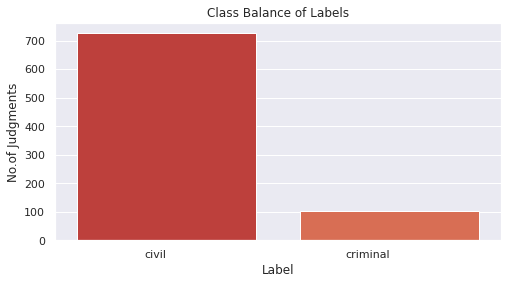

In [19]:
#visualise class balance
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))

color= sns.color_palette("RdYlGn", 10)

sns.barplot(x="label", y="Count", data=class_bal, palette=color ).set(title="Class Balance of Labels")
plt.xticks(rotation=0, ha='right')

plt.xlabel("Label")
plt.ylabel("No.of Judgments")
plt.savefig("ClassBal_Original_2")

Prepare dataset for training

In [20]:
#drop title column
binary_label_final = binary_labels.drop(columns=["title"])
binary_label_final

,text,label
0,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,civil
1,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,civil
2,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,civil
3,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,civil
4,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,civil
...,...,...
912,Hilary Term \n[2023] UKSC 12 \nOn appeal from:...,civil
913,Hilary Term \n[2023] UKSC 13 \nOn appeal from:...,civil
914,Easter Term \n[2023] UKSC 14 \nOn appeal from:...,civil
915,Michaelmas Term \n[2022] UKSC 32 \n\nJUDGMENT ...,civil


Splitting the data to training and test sets

In [21]:
#training set: 80% of the samples
#test set: 20% of the samples
#this is so that the test set can be kept separate only to evaluate performance
from sklearn.model_selection import train_test_split

x = binary_label_final.drop("label", axis=1)
y = binary_label_final["label"]

training_data, test_data = train_test_split(binary_label_final, test_size=0.2, stratify=y, random_state=42)

#check size of each set
print("Size of Training samples: ", len(training_data))
print("Size of Test samples    : ", len(test_data))
print()

#check class distribution across both sets
train_count = training_data["label"].value_counts()
test_count = test_data["label"].value_counts()

Size of Training samples:  663
Size of Test samples    :  166



In [22]:
print("The Number of classes in in Training Samples are:")
print(train_count)

The Number of classes in in Training Samples are:
civil       581
criminal     82
Name: label, dtype: int64


In [23]:
print("The Number of classes in in Test Samples are:")
print(test_count)

The Number of classes in in Test Samples are:
civil       145
criminal     21
Name: label, dtype: int64


In [24]:
#convert object type to string for preprocessing
training_data = training_data.astype({"text":"string"})
test_data = test_data.astype({"text":"string"})

#check data types
print("Data types in Training set :\n", training_data.dtypes)
print()
print("Data types in Test set :\n", test_data.dtypes)

Data types in Training set :
 text     string
label    object
dtype: object

Data types in Test set :
 text     string
label    object
dtype: object


In [25]:
#check for missing data
print("Missing data in Training Set: \n", training_data.isna().sum())
print()
print("Missing data in Test Set: \n", test_data.isna().sum())

Missing data in Training Set: 
 text     0
label    0
dtype: int64

Missing data in Test Set: 
 text     0
label    0
dtype: int64


In [26]:
training_data

,text,label
506,Trinity Term [2016] UKSC 28 On appeal from: ...,civil
108,Hilary Term [2011] UKSC 12 On appeal from: 2...,civil
323,Hilary Term [2013] UKSC 5 On appeal from: [2...,civil
818,Michaelmas Term [2021] UKSC 49 On appeal fro...,criminal
787,Easter Term [2020] UKSC 22 On appeal from: [...,civil
...,...,...
466,Trinity Term [2016] UKSC 47 On appeal from: ...,civil
73,Trinity Term [2010] UKSC 39 On appeal from: ...,criminal
133,Easter Term [2011] UKSC 22 On appeal from: [...,civil
627,Trinity Term [2018] UKSC 30 On appeal from: ...,civil


Now that the training and test samples are prepared, the two samples need to be tokenised. 

In [27]:
#in order to tokenise:

#create a list of articles + labels for both training and test samples
training_text = training_data["text"].tolist()
training_label = training_data["label"].tolist()

test_text = test_data["text"].tolist()
test_label = test_data["label"].tolist()

#confirm the same no.of articles and labels in both samples
print("No.of judgments in Training set: ", len(training_text))
print("No.of labels in Training set: ", len(training_label))
print("No.of judgments in Test set: ", len(test_text))
print("No.of labels in Training set: ", len(test_label))

No.of judgments in Training set:  663
No.of labels in Training set:  663
No.of judgments in Test set:  166
No.of labels in Training set:  166


In [28]:
#tokenize each article to its lowercase words

training_tokens = []
training_label_final = []
test_tokens = []
test_label_final = []

for i in range(len(training_text)):
    try: 
        tokens = word_tokenize(training_text[i].lower()) #tokenise+lowercase
        training_tokens.append(tokens)
        training_label_final.append(training_label[i])
    except:
        pass

for x in range(len(test_text)):
    try: 
        tokens = word_tokenize(test_text[x].lower()) #tokenise+lowercase
        test_tokens.append(tokens)
        test_label_final.append(test_label[x])
    except:
        pass

#confirm the same no.of articles and labels in both samples
print("Total no. of training samples: ", len(training_tokens))
print("Total no. of training labels: ", len(training_label_final))
print("Total no. of test samples: ", len(test_tokens))
print("Total no. of test labels: ", len(test_label_final))

Total no. of training samples:  663
Total no. of training labels:  663
Total no. of test samples:  166
Total no. of test labels:  166


In [ ]:
#print("Training sample 1: ", training_tokens[0])

In [30]:
#remove stopwords and punctuation

pTraining_articles = training_tokens
pTraining_label = training_label_final
pTest_articles = test_tokens
pTest_label = test_label_final

stopwords_english = stopwords.words('english') # Load the stop words list for English in variable

for i in range(len(pTraining_articles)):
    new_tokens = []
    for word in pTraining_articles[i]:
        word = word.replace("-", "") #remove hyphens
        word = word.replace(".", "") #remove dots to normalise abbreiviations
        #select only tokens with letters a to z
        regex_check = re.match("[a-z]+", word)
        if (regex_check!=None):
            if((regex_check.group()==word) and (word not in stopwords_english)): # Check regex and stopwords
                new_tokens.append(word)
    pTraining_articles[i] = new_tokens

for x in range(len(pTest_articles)):
    new_tokens = []
    for word in pTest_articles[x]:
        word = word.replace("-", "") #remove hyphens
        word = word.replace(".", "") #remove dots to normalise abbreiviations
        #select only tokens with letters a to z
        regex_check = re.match("[a-z]+", word)
        if (regex_check!=None):
            if((regex_check.group()==word) and (word not in stopwords_english)): # Check regex and stopwords
                new_tokens.append(word)
    pTest_articles[x] = new_tokens
    
print("Total no. of training samples: ", len(pTraining_articles))
print("Total no. of training labels: ", len(pTraining_label))
print("Total no. of test samples: ", len(pTest_articles))
print("Total no. of test labels: ", len(pTest_label))

#https://www.freecodecamp.org/news/list-index-out-of-range-python-error-solved/
#citation for else: i +=1

Total no. of training samples:  663
Total no. of training labels:  663
Total no. of test samples:  166
Total no. of test labels:  166


In [ ]:
#print("Training sample 1 [lowercase,no symbols,no numbers,no punctuation]: \n ", pTraining_articles[0])

In [32]:
pp_training_text = pTraining_articles
pp_test_text = pTest_articles

training_label_final = pTraining_label
test_label_final = pTest_label

#save training and test data as dataframes

#create two dataframes
clean_training_data = pd.DataFrame(columns=["alltext","label"])
clean_test_data = pd.DataFrame(columns=["alltext", "label"])

#loop text and labels into each dataframe
for i in range(len(training_label_final)):
    clean_training_data.loc[i,"alltext"] = pp_training_text[i]
    clean_training_data.loc[i,"label"] = training_label_final[i]
    
for i in range(len(test_label_final)):
    clean_test_data.loc[i, "alltext"] = pp_test_text[i]
    clean_test_data.loc[i,"label"] = test_label_final[i]

#convert list of strings using .join
clean_training_data["alltext"] = clean_training_data["alltext"].apply(" ".join)
clean_test_data["alltext"] = clean_test_data["alltext"].apply(" ".join)

print("Snippet of cleaned training data: \n", clean_training_data.head())
print()
print("Snippet of cleaned test data: \n", clean_test_data.head())

Snippet of cleaned training data: 
                                              alltext     label
0  trinity term uksc appeal ewca civ judgment mcd...     civil
1  hilary term uksc appeal ewca civ judgment walu...     civil
2  hilary term uksc appeal ewca civ judgment vtb ...     civil
3  michaelmas term uksc appeal ewca civ judgment ...  criminal
4  easter term uksc appeal ewca civ judgment fowl...     civil

Snippet of cleaned test data: 
                                              alltext     label
0  trinity term uksc appeal ewca civ judgment r a...  criminal
1  easter term uksc appeal ewca civ judgment r ap...     civil
2  uksc appeal ewca civ judgment goldtrail travel...     civil
3  trinity term uksc appeal ewca civ judgment hj ...     civil
4  trinity term uksc appeal csih judgment sadovsk...     civil


In [33]:
#remove texts that are less than 50 characters long to remove noise (as it would not add much to the learning process)
#should remove texts that are empty as well.
clean_training_data.drop(clean_training_data[clean_training_data.alltext.str.len() < 50].index, inplace=True)
clean_test_data.drop(clean_test_data[clean_test_data.alltext.str.len() < 50].index, inplace=True)


#reduce the no.of words to be considered for each text to 200 (for faster performance)
def truncate_text_to_max_words(text,max_words): # Keep only the first max_words of each text
    text = text.split(maxsplit=max_words)
    text = ' '.join(text[:max_words])
    return text

max_words = 70000 # Set the maximum number of words to be considered for each document 

# Truncate text to first 70000 words
clean_training_data['alltext'] = clean_training_data['alltext'].apply(truncate_text_to_max_words,args=(max_words,))
clean_test_data['alltext'] = clean_test_data['alltext'].apply(truncate_text_to_max_words,args=(max_words,))

print("Samples in Training Set: ", len(clean_training_data["alltext"]))
print("Labels in Training Set: ", len(clean_training_data["label"]))
print("Samples in Test Set: ", len(clean_test_data["alltext"]))
print("Labels in Test Set: ", len(clean_test_data["label"]))

Samples in Training Set:  663
Labels in Training Set:  663
Samples in Test Set:  166
Labels in Test Set:  166


In [34]:
final_training = clean_training_data
final_test = clean_test_data

In [35]:
#convert training and test texts to list
training_text_final = final_training["alltext"].tolist()
training_label_final = final_training["label"].tolist()

test_text_final = final_test["alltext"].tolist()
test_label_final = final_test["label"].tolist()

print("Samples in Training Set: ", len(training_text_final))
print("Labels in Training Set: ", len(training_label_final))
print("Samples in Test Set: ", len(test_text_final))
print("Labels in Test Set: ", len(test_label_final))

Samples in Training Set:  663
Labels in Training Set:  663
Samples in Test Set:  166
Labels in Test Set:  166


In [36]:
clean_training_data

,alltext,label
0,trinity term uksc appeal ewca civ judgment mcd...,civil
1,hilary term uksc appeal ewca civ judgment walu...,civil
2,hilary term uksc appeal ewca civ judgment vtb ...,civil
3,michaelmas term uksc appeal ewca civ judgment ...,criminal
4,easter term uksc appeal ewca civ judgment fowl...,civil
...,...,...
658,trinity term uksc appeal ewca civ judgment bai...,civil
659,trinity term uksc appeal ewca crim judgment r ...,criminal
660,easter term uksc appeal ewca civ judgment fa i...,civil
661,trinity term uksc appeal ewca civ judgment pro...,civil


Splitting the training data to training and validation data for hyperparameter testing

In [37]:
#create training dataframe.
training_df = clean_training_data.copy()

In [38]:
x = training_df.drop("label", axis=1)
y = training_df["label"]

In [39]:
training_data, valid_data = train_test_split(training_df, test_size=0.2, stratify=y, random_state=42)

#check size of each set
print("Size of Training samples: ", len(training_data))
print("Size of validation samples    : ", len(valid_data))
print()

#check class distribution across both sets
train_count = training_data["label"].value_counts()
valid_count = valid_data["label"].value_counts()

Size of Training samples:  530
Size of validation samples    :  133



In [40]:
train_count

civil       464
criminal     66
Name: label, dtype: int64

In [41]:
valid_count

civil       117
criminal     16
Name: label, dtype: int64

### Rebalance Classes

Now that the training and test samples have been preprocessed and cleaned, it is necessary to evaluate class balance.

In [42]:
#check the class balance
print("The Number of training classes are:")
print(training_data['label'].value_counts())

The Number of training classes are:
civil       464
criminal     66
Name: label, dtype: int64


In [43]:
#there is a severe imbalance of classes
#to rebalance classes, prepare each class as follows: 

df_majority_civil = training_data[training_data['label']=='civil']
df_minority_crim = training_data[training_data['label']=='criminal']

In [44]:
df_minority_upsampled_crim = resample(df_minority_crim, replace=True, n_samples=464)

#code adapted from: https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes

In [45]:
#code to get minority civil samples upsamplped
df_upsampled = pd.concat([df_majority_civil, df_minority_upsampled_crim])

#ensure that the classes are now balanced
print("The Number of classes are:")
print(df_upsampled['label'].value_counts())

The Number of classes are:
civil       464
criminal    464
Name: label, dtype: int64


In [49]:
train = df_upsampled

In [50]:
train_text = train["alltext"].tolist()
train_label = train["label"].tolist()

valid_text = valid_data["alltext"].tolist()
valid_label = valid_data["label"].tolist()

test_text = clean_test_data["alltext"].tolist()
test_label = clean_test_data["label"].tolist()

# Check lengths
print(len(train_text))
print(len(train_label))
print()

print(len(valid_text))
print(len(valid_label))
print()

print(len(test_text))
print(len(test_label))

928
928

133
133

166
166


In [51]:
pd.value_counts(np.array(train_label))

criminal    464
civil       464
dtype: int64

In [52]:
###create training and test dataframes
final_training = pd.DataFrame({"training_text": train_text, "training_label": train_label})

In [53]:
final_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   training_text   928 non-null    object
 1   training_label  928 non-null    object
dtypes: object(2)
memory usage: 14.6+ KB


In [47]:
#save df for future use
final_training.to_csv("UKSC_training_data_NN_2labels.csv", index=False)

### Implementing Traditional Classifiers

In [123]:
#NAIVE BAYES
#text classification using a Multinomial Naive Bayes

#build the Naive Bayes model by setting a pipeline where the input is first converted
#to TF-IDF vectors and then a Multinomial Naive Bayes is used
model1_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_nb.fit(train_text, train_label) # Train the model on the training data

predicted_categories1_nb = model1_nb.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories1_nb.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'criminal', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


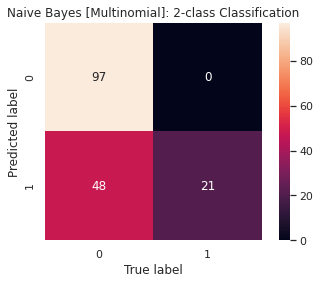

Accuracy:	0.710843
F1-score:	0.634160
Precision:	0.652174
Recall:		0.834483

Classification performance of [Multinomial] Naives Bayes Model:
              precision    recall  f1-score   support

       civil       1.00      0.67      0.80       145
    criminal       0.30      1.00      0.47        21

    accuracy                           0.71       166
   macro avg       0.65      0.83      0.63       166
weighted avg       0.91      0.71      0.76       166



In [124]:
# Plot the confusion matrix for model 1: Multinomial Naive Bayes classifier
mat1_nb = confusion_matrix(test_label, predicted_categories1_nb)
sns.heatmap(mat1_nb.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Naive Bayes [Multinomial]: 2-class Classification")
plt.savefig("NB2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories1_nb))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories1_nb, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories1_nb, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories1_nb, average='macro'))
print("\nClassification performance of [Multinomial] Naives Bayes Model:\n%s" % classification_report(test_label, predicted_categories1_nb))

In [125]:
#NAIVE BAYES
#text classification using a Bernoulli Naive Bayes

# Build the Naive Bayes model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a Multinomial Naive Bayes is used
model1_nb2 = make_pipeline(TfidfVectorizer(), BernoulliNB())
model1_nb2.fit(train_text, train_label) # Train the model on the training data

predicted_categories1_nb2 = model1_nb2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories1_nb2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


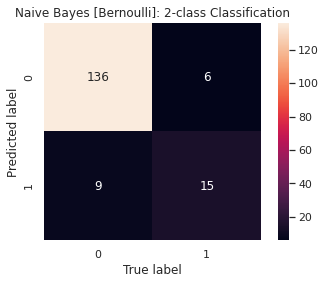

Accuracy:	0.909639
F1-score:	0.807201
Precision:	0.791373
Recall:		0.826108

Classification performance of [Bernoulli] Naives Bayes Model:
              precision    recall  f1-score   support

       civil       0.96      0.94      0.95       145
    criminal       0.62      0.71      0.67        21

    accuracy                           0.91       166
   macro avg       0.79      0.83      0.81       166
weighted avg       0.92      0.91      0.91       166



In [126]:
# Plot the confusion matrix for model 1: Bernoulli Naive Bayes classifier
mat1_nb = confusion_matrix(test_label, predicted_categories1_nb2)
sns.heatmap(mat1_nb.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Naive Bayes [Bernoulli]: 2-class Classification")
plt.savefig("NB_Bernoulli_Performance2")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories1_nb2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories1_nb2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories1_nb2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories1_nb2, average='macro'))
print("\nClassification performance of [Bernoulli] Naives Bayes Model:\n%s" % classification_report(test_label, predicted_categories1_nb2))

### KNN CLASSIFIER

In [138]:
# Build the kNN model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a kNN classifier for k=5(default) is used
model2_knn1 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
model2_knn1.fit(train_text, train_label) # Train the model on the training data
predicted_categories2_knn1 = model2_knn1.predict(valid_text) # Predict the categories of the test data
print("Predicted:",predicted_categories2_knn1.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['civil', 'civil', 'criminal', 'criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']
Ground truth: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']


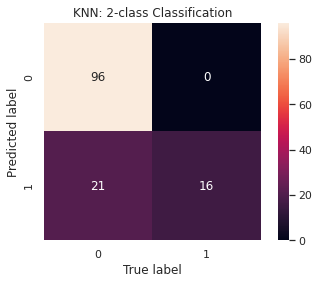

Accuracy:	0.842105
F1-score:	0.752591
Precision:	0.716216
Recall:		0.910256

Classification performance of KNN model (k=5):
              precision    recall  f1-score   support

       civil       1.00      0.82      0.90       117
    criminal       0.43      1.00      0.60        16

    accuracy                           0.84       133
   macro avg       0.72      0.91      0.75       133
weighted avg       0.93      0.84      0.87       133



In [139]:
# Plot the confusion matrix for model 2: KNN Classifier (KNN=5 - default)
mat2_knn1 = confusion_matrix(valid_label, predicted_categories2_knn1)
sns.heatmap(mat2_knn1.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN: 2-class Classification")

plt.savefig("KNN_default_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories2_knn1))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories2_knn1, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories2_knn1, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories2_knn1, average='macro'))
print("\nClassification performance of KNN model (k=5):\n%s" % classification_report(valid_label, predicted_categories2_knn1))

In [130]:
#selecting optimum k value
#creating a pipeline for vectorizing the data
vectorizer = TfidfVectorizer()
train_text_vectorized = vectorizer.fit_transform(train_text)

#originally the same pipeline was used for fitting and cross validation.
#this resulted in identical KNN scores for increasing k values.
#this was debugged by separating the pipeline into two: 
### 1. the data was vectorized using TfidfVectorizer()
### 2. it was vectorized again to fit and cross-validate the KNN model.

k_values = range(1, 20)
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, train_text_vectorized, train_label, cv=5, error_score="raise")
    print("k:", k, "Score:", score.mean())
    mean_scores.append(score.mean())
    
#code adapted from: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

k: 1 Score: 0.9504504504504505
k: 2 Score: 0.9482941005521651
k: 3 Score: 0.9138215634989828
k: 4 Score: 0.9159837256611449
k: 5 Score: 0.8890380703283929
k: 6 Score: 0.8858122638767799
k: 7 Score: 0.8674920081371695
k: 8 Score: 0.8609938971229294
k: 9 Score: 0.8480616099970938
k: 10 Score: 0.8501947108398721
k: 11 Score: 0.8232548677709968
k: 12 Score: 0.8307991862830573
k: 13 Score: 0.8254402789886661
k: 14 Score: 0.8351176983435048
k: 15 Score: 0.8286486486486486
k: 16 Score: 0.836222028480093
k: 17 Score: 0.8340424295263006
k: 18 Score: 0.8329729729729729
k: 19 Score: 0.827579192095321


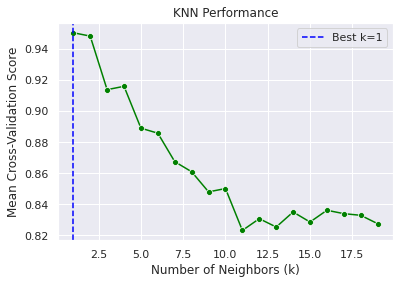

In [131]:
#to plot the highest performing k value
max_score = np.argmax(mean_scores)
high_k = k_values[max_score]

sns.set(style="dark")
sns.lineplot(x=k_values, y=mean_scores, marker='o', color="green")

plt.axvline(x=high_k, color='blue', linestyle='--', label=f'Best k={high_k}')
plt.legend()

plt.title('KNN Performance')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation Score')
plt.savefig('optimal_k_2_performance.png')

plt.grid(True)
plt.show()

In [132]:
# Build the kNN model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a kNN classifier for k=1 is used
model2_knn1 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=1))
model2_knn1.fit(train_text, train_label) # Train the model on the training data
predicted_categories2_knn1 = model2_knn1.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories2_knn1.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


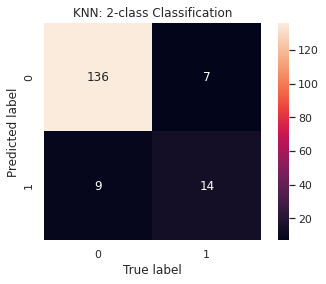

Accuracy:	0.903614
F1-score:	0.790404
Precision:	0.779872
Recall:		0.802299

Classification performance of KNN model (k=1):
              precision    recall  f1-score   support

       civil       0.95      0.94      0.94       145
    criminal       0.61      0.67      0.64        21

    accuracy                           0.90       166
   macro avg       0.78      0.80      0.79       166
weighted avg       0.91      0.90      0.91       166



In [133]:
# Plot the confusion matrix for model 2: KNN Classifier (KNN=1)
mat2_knn1 = confusion_matrix(test_label, predicted_categories2_knn1)
sns.heatmap(mat2_knn1.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN: 2-class Classification")

plt.savefig("KNN1_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories2_knn1))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories2_knn1, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories2_knn1, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories2_knn1, average='macro'))
print("\nClassification performance of KNN model (k=1):\n%s" % classification_report(test_label, predicted_categories2_knn1))

### SVM Classifier

In [134]:
# Build the SVM model by setting a pipeline where the input is first converted
#kernel=linear which is recommended for text classification
model3_svm = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="linear"))

model3_svm.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm = model3_svm.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


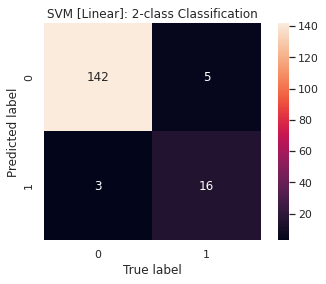

Accuracy:	0.951807
F1-score:	0.886301
Precision:	0.904046
Recall:		0.870608

Classification performance of SVM (kernel=linear):
              precision    recall  f1-score   support

       civil       0.97      0.98      0.97       145
    criminal       0.84      0.76      0.80        21

    accuracy                           0.95       166
   macro avg       0.90      0.87      0.89       166
weighted avg       0.95      0.95      0.95       166



In [135]:
#plot the confusion matrix for model 3: SVM, kernel=linear
mat3_svm = confusion_matrix(test_label, predicted_categories3_svm)
sns.heatmap(mat3_svm.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Linear]: 2-class Classification")
plt.savefig("SVM_Linear_2_Performance")
plt.show()

#compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm, average='macro'))
print("\nClassification performance of SVM (kernel=linear):\n%s" % classification_report(test_label, predicted_categories3_svm))

In [141]:
#kernel=rbf to test non-linearity between features and class
model3_svm2 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="rbf"))

model3_svm2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm2 = model3_svm2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


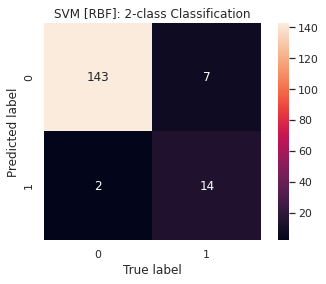

Accuracy:	0.945783
F1-score:	0.863124
Precision:	0.914167
Recall:		0.826437

Classification performance of SVM model (kernel=rbf):
              precision    recall  f1-score   support

       civil       0.95      0.99      0.97       145
    criminal       0.88      0.67      0.76        21

    accuracy                           0.95       166
   macro avg       0.91      0.83      0.86       166
weighted avg       0.94      0.95      0.94       166



In [137]:
#plot the confusion matrix for model 3: SVM, kernel=rbf
mat3_svm2 = confusion_matrix(test_label, predicted_categories3_svm2)
sns.heatmap(mat3_svm2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [RBF]: 2-class Classification")

plt.savefig("SVM_rbf_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm2, average='macro'))
print("\nClassification performance of SVM model (kernel=rbf):\n%s" % classification_report(test_label, predicted_categories3_svm2))

In [143]:
#kernel=poly (polynomial) to test non-linearity between features and class
model3_svm3 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly"))

model3_svm3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm3 = model3_svm3.predict(valid_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']


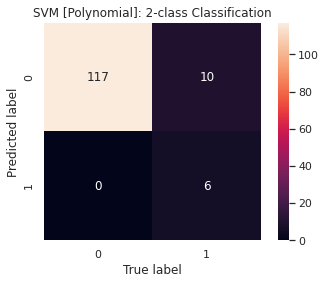

Accuracy:	0.924812
F1-score:	0.752235
Precision:	0.960630
Recall:		0.687500

Classification performance of SVM model (kernel=poly):
              precision    recall  f1-score   support

       civil       0.92      1.00      0.96       117
    criminal       1.00      0.38      0.55        16

    accuracy                           0.92       133
   macro avg       0.96      0.69      0.75       133
weighted avg       0.93      0.92      0.91       133



In [144]:
#plot the confusion matrix for model 3: SVM, kernel="poly"
mat3_svm3 = confusion_matrix(valid_label, predicted_categories3_svm3)
sns.heatmap(mat3_svm3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Polynomial]: 2-class Classification")

plt.savefig("SVM_poly_2_default_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories3_svm3))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories3_svm3, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories3_svm3, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories3_svm3, average='macro'))
print("\nClassification performance of SVM model (kernel=poly):\n%s" % classification_report(valid_label, predicted_categories3_svm3))

Using Grid Search to identify best number of degrees for kernel=poly

In [150]:
#dict with hyperparameter values
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4]
}

#svm with kernel=poly
model3_svm3_poly = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly"))

#grid search with cross-validation=5
grid_search = GridSearchCV(model3_svm3_poly, param_grid, cv=5)
grid_search.fit(train_text, train_label)

best_degree = grid_search.best_params_['svc__degree']
best_C = grid_search.best_params_['svc__C']

#code guided by https://aneesha.medium.com/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

In [161]:
print("The best degree for SVM with Polynomial kernel: ", best_degree)
print("The best C for SVM with Polynomial kernel: ", best_C)

The best degree for SVM with Polynomial kernel:  4
The best C for SVM with Polynomial kernel:  1


In [162]:
#kernel=poly (polynomial) to test non-linearity between features and class
#with 4 degrees
model3_svm3 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly", degree=4, C=1))

model3_svm3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm3 = model3_svm3.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


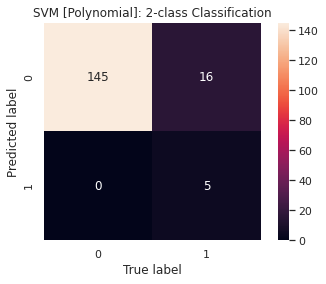

Accuracy:	0.903614
F1-score:	0.666164
Precision:	0.950311
Recall:		0.619048

Classification performance of (tuned) SVM model (kernel=poly):
              precision    recall  f1-score   support

       civil       0.90      1.00      0.95       145
    criminal       1.00      0.24      0.38        21

    accuracy                           0.90       166
   macro avg       0.95      0.62      0.67       166
weighted avg       0.91      0.90      0.88       166



In [163]:
#plot the confusion matrix for model 3: SVM, kernel="poly"
mat3_svm3 = confusion_matrix(test_label, predicted_categories3_svm3)
sns.heatmap(mat3_svm3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Polynomial]: 2-class Classification")

plt.savefig("SVM_poly_2_tuned_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm3))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm3, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm3, average='macro'))
print("\nClassification performance of (tuned) SVM model (kernel=poly):\n%s" % classification_report(test_label, predicted_categories3_svm3))

### Decision Tree

In [164]:
#build the DCT model by setting a pipeline where the input is first converted to tfid
#model built on default parameters, except criterion="entropy"
model6_dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(criterion="entropy"))

model6_dt.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt = model6_dt.predict(valid_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']
Ground truth: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']


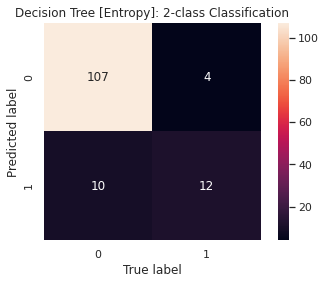

Accuracy:	0.894737
F1-score:	0.785088
Precision:	0.754709
Recall:		0.832265

Classification performance of Decision Tree:
              precision    recall  f1-score   support

       civil       0.96      0.91      0.94       117
    criminal       0.55      0.75      0.63        16

    accuracy                           0.89       133
   macro avg       0.75      0.83      0.79       133
weighted avg       0.91      0.89      0.90       133



In [165]:
# Plot the confusion matrix for model 6: Decision Tree
model6_dt = confusion_matrix(valid_label, predicted_categories6_dt)
sns.heatmap(model6_dt.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Decision Tree [Entropy]: 2-class Classification")

plt.savefig("4 DecisionT_EntropyDefault_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories6_dt))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories6_dt, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories6_dt, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories6_dt, average='macro'))
print("\nClassification performance of Decision Tree:\n%s" % classification_report(valid_label, predicted_categories6_dt))

In [166]:
#build the DCT model by setting a pipeline where the input is first converted to tfid
#model built on all default parameters (criterion="gini")
model6_dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

model6_dt.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt = model6_dt.predict(valid_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']
Ground truth: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']


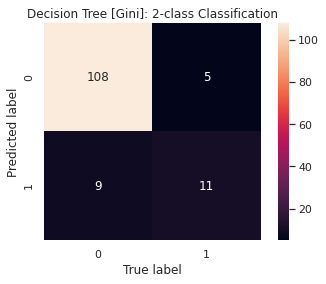

Accuracy:	0.894737
F1-score:	0.775121
Precision:	0.752876
Recall:		0.805288

Classification performance of Decision Tree:
              precision    recall  f1-score   support

       civil       0.96      0.92      0.94       117
    criminal       0.55      0.69      0.61        16

    accuracy                           0.89       133
   macro avg       0.75      0.81      0.78       133
weighted avg       0.91      0.89      0.90       133



In [167]:
# Plot the confusion matrix for model 6: Decision Tree
model6_dt = confusion_matrix(valid_label, predicted_categories6_dt)
sns.heatmap(model6_dt.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Decision Tree [Gini]: 2-class Classification")

plt.savefig("4a DecisionT_Gini_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories6_dt))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories6_dt, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories6_dt, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories6_dt, average='macro'))
print("\nClassification performance of Decision Tree:\n%s" % classification_report(valid_label, predicted_categories6_dt))

In [168]:
#hyperparameter tuning
#specifying hyperparameter ranges
param_dist = {'decisiontreeclassifier__max_depth': randint(1, 20),
              'decisiontreeclassifier__min_samples_split': randint(2, 20),
              'decisiontreeclassifier__min_samples_leaf': randint(1, 10)}

dt_pipeline = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

#find best hyperparameters through random search
rand_search = RandomizedSearchCV(dt_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5)

#fit rand_search to the data
rand_search.fit(train_text, train_label)

#adapted from otaviomguerra/decision_tree_with_RandomizedSearch.py at https://gist.github.com/otaviomguerra/51df7a4cff28f92de7105f12a0724115
#adapted from https://www.datacamp.com/tutorial/random-forests-classifier-python

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier())]),
                   param_distributions={'decisiontreeclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff33e0a5d60>,
                                        'decisiontreeclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff33ca54a90>,
                                        'decisiontreeclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff33ca163d0>})

In [169]:
#creating variable for the best model
best_dt = rand_search.best_estimator_

#identify the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#adapted from https://www.datacamp.com/tutorial/random-forests-classifier-python

Best hyperparameters: {'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__min_samples_split': 5}


In [170]:
#rerunning Decision Tree algorithm with tuned parameters + gini

model6_dt2 = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=5))

model6_dt2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt2 = model6_dt2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


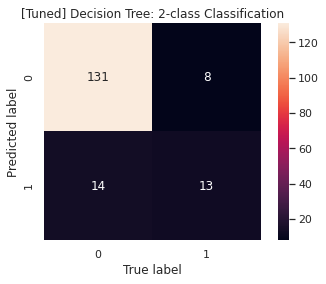

Accuracy:	0.867470
F1-score:	0.732101
Precision:	0.711964
Recall:		0.761248

Classification performance of (Tuned) Decision Tree:
              precision    recall  f1-score   support

       civil       0.94      0.90      0.92       145
    criminal       0.48      0.62      0.54        21

    accuracy                           0.87       166
   macro avg       0.71      0.76      0.73       166
weighted avg       0.88      0.87      0.87       166



In [171]:
# Plot the confusion matrix for model 6: tuned Decision Tree
model6_dt2 = confusion_matrix(test_label, predicted_categories6_dt2)
sns.heatmap(model6_dt2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("[Tuned] Decision Tree: 2-class Classification")
plt.savefig("DecisionT_HyperGini_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt2, average='macro'))
print("\nClassification performance of (Tuned) Decision Tree:\n%s" % classification_report(test_label, predicted_categories6_dt2))

In [172]:
#rerunning Decision Tree algorithm with tuned parameters + entropy

model6_dt3 = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=5, criterion="entropy"))

model6_dt3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt3 = model6_dt3.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


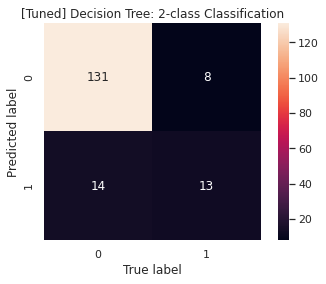

Accuracy:	0.867470
F1-score:	0.732101
Precision:	0.711964
Recall:		0.761248

Classification performance of (Tuned) Decision Tree (Entropy):
              precision    recall  f1-score   support

       civil       0.94      0.90      0.92       145
    criminal       0.48      0.62      0.54        21

    accuracy                           0.87       166
   macro avg       0.71      0.76      0.73       166
weighted avg       0.88      0.87      0.87       166



In [173]:
# Plot the confusion matrix for model 6: tuned Decision Tree + entropy
model6_dt3 = confusion_matrix(test_label, predicted_categories6_dt2)
sns.heatmap(model6_dt3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("[Tuned] Decision Tree: 2-class Classification")

plt.savefig("DecisionT_Tuned_Entropy 2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt3))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt3, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt3, average='macro'))
print("\nClassification performance of (Tuned) Decision Tree (Entropy):\n%s" % classification_report(test_label, predicted_categories6_dt3))

### Random Forest Classifier

In [180]:
# Build the RF model by setting a pipeline where the input is first converted
#no number of trees is specified: modl is run using default (100)
model4_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

model4_rf.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories4_rf = model4_rf.predict(valid_label) # Predict the categories of the test data
print("Predicted:",predicted_categories4_rf.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


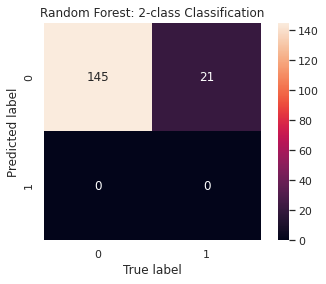

Accuracy:	0.873494
F1-score:	0.466238
Precision:	0.436747
Recall:		0.500000

Classification performance of Random Forest Classifier:
              precision    recall  f1-score   support

       civil       0.87      1.00      0.93       145
    criminal       0.00      0.00      0.00        21

    accuracy                           0.87       166
   macro avg       0.44      0.50      0.47       166
weighted avg       0.76      0.87      0.81       166



/apps/jupyterhub/COMP42415/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/jupyterhub/COMP42415/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
#plot the confusion matrix for model 4: Random Forest (default no.of trees)
mat4_rf = confusion_matrix(valid_label, predicted_categories4_rf)
sns.heatmap(mat4_rf.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Random Forest: 2-class Classification")

plt.savefig("RF_2_testing_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories4_rf))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories4_rf, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories4_rf, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories4_rf, average='macro'))
print("\nClassification performance of Random Forest Classifier:\n%s" % classification_report(valid_label, predicted_categories4_rf))


In [176]:
#randomint to 1000 (50,1000)
#define hyperparameter ranges
param_dist = {'randomforestclassifier__n_estimators': randint(50, 1000),
              'randomforestclassifier__max_depth': randint(1, 20)}

# Create a random forest classifier pipeline
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_text, train_label)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff33cc5e220>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff33c863220>})

In [177]:
#variable for the best model
best_rf = rand_search.best_estimator_

#print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__n_estimators': 444}


In [178]:
#build the RF model by setting a pipeline where the input is first converted
#no.of trees=444
model4_rf2 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=444, max_depth=14))

model4_rf2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories4_rf2 = model4_rf2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories4_rf2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


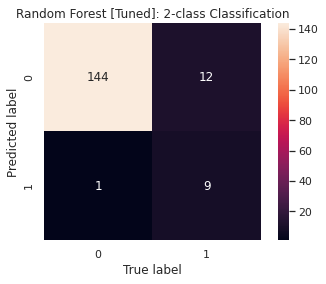

Accuracy:	0.921687
F1-score:	0.768728
Precision:	0.911538
Recall:		0.710837

Classification performance of Random Forest Classifier (No.of Trees=444):
              precision    recall  f1-score   support

       civil       0.92      0.99      0.96       145
    criminal       0.90      0.43      0.58        21

    accuracy                           0.92       166
   macro avg       0.91      0.71      0.77       166
weighted avg       0.92      0.92      0.91       166



In [182]:
#plot the confusion matrix for model 4: Random Forest (no.of trees=444)
mat4_rf2 = confusion_matrix(test_label, predicted_categories4_rf2)
sns.heatmap(mat4_rf2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Random Forest [Tuned]: 2-class Classification")

plt.savefig("RF444_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories4_rf2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories4_rf2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories4_rf2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories4_rf2, average='macro'))
print("\nClassification performance of Random Forest Classifier (No.of Trees=444):\n%s" % classification_report(test_label, predicted_categories4_rf2))

### Logistic Regression

In [183]:
from sklearn.linear_model import LogisticRegression
# Build the LR model by setting a pipeline where the input is first converted
#to tfid
model5_lr = make_pipeline(TfidfVectorizer(), LogisticRegression())

model5_lr.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories5_lr = model5_lr.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories5_lr.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


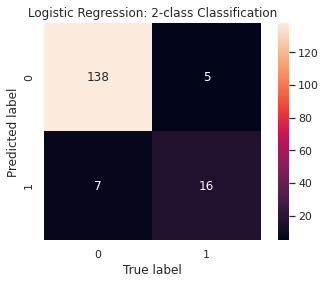

Accuracy:	0.927711
F1-score:	0.842803
Precision:	0.830344
Recall:		0.856814

Classification performance of Logistic Regression:
              precision    recall  f1-score   support

       civil       0.97      0.95      0.96       145
    criminal       0.70      0.76      0.73        21

    accuracy                           0.93       166
   macro avg       0.83      0.86      0.84       166
weighted avg       0.93      0.93      0.93       166



In [184]:
# Plot the confusion matrix for model 5: Logistic Regression
mat5_lr = confusion_matrix(test_label, predicted_categories5_lr)
sns.heatmap(mat5_lr.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Logistic Regression: 2-class Classification")

plt.savefig("LogReg_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories5_lr))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories5_lr, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories5_lr, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories5_lr, average='macro'))
print("\nClassification performance of Logistic Regression:\n%s" % classification_report(test_label, predicted_categories5_lr))

### Gradient Boosting Classifier 

In [54]:
# Build the GB classifier by setting a pipeline where the input is first converted
#to tfid
model7_gbc = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())

model7_gbc.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories7_gbc = model7_gbc.predict(valid_text) # Predict the categories of the test data
print("Predicted:",predicted_categories7_gbc.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",valid_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal']


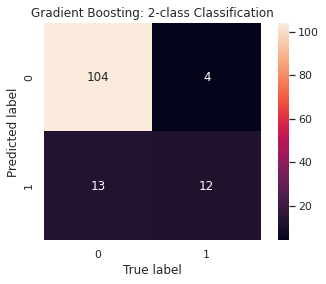

Accuracy:	0.872180
F1-score:	0.754905
Precision:	0.721481
Recall:		0.819444

Classification performance of Gradient Boosting Classifier:
              precision    recall  f1-score   support

       civil       0.96      0.89      0.92       117
    criminal       0.48      0.75      0.59        16

    accuracy                           0.87       133
   macro avg       0.72      0.82      0.75       133
weighted avg       0.90      0.87      0.88       133



In [56]:
# Plot the confusion matrix for model 7: Gradient Boosting classifier
model7_gbc = confusion_matrix(valid_label, predicted_categories7_gbc)
sns.heatmap(model7_gbc.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Gradient Boosting: 2-class Classification")

plt.savefig("GBC_default_2v_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(valid_label, predicted_categories7_gbc))
print("F1-score:\t%f" % f1_score(valid_label, predicted_categories7_gbc, average='macro'))
print("Precision:\t%f" % precision_score(valid_label, predicted_categories7_gbc, average='macro'))
print("Recall:\t\t%f" % recall_score(valid_label, predicted_categories7_gbc, average='macro'))
print("\nClassification performance of Gradient Boosting Classifier:\n%s" % classification_report(valid_label, predicted_categories7_gbc))

In [57]:
#test data for hyperparameter tuning

# Define hyperparameter ranges
param_dist = {'gradientboostingclassifier__n_estimators': randint(50, 1000),
              'gradientboostingclassifier__max_depth': randint(1, 20),
              'gradientboostingclassifier__min_samples_split': randint(2, 20),
              'gradientboostingclassifier__min_samples_leaf': randint(1, 10)
             }

# Create a random forest classifier pipeline
gbc_pipeline = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(gbc_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_text, train_label)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier())]),
                   n_iter=5,
                   param_distributions={'gradientboostingclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6956182670>,
                                        'gradientboostingclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6957e70310>,
                                        'gradientboostingclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f69567c2e80>,
                                        'gradientboostingclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f695425f700>})

In [58]:
#variable for the best model
best_gbc = rand_search.best_estimator_

#print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__min_samples_leaf': 9, 'gradientboostingclassifier__min_samples_split': 8, 'gradientboostingclassifier__n_estimators': 598}


In [59]:
# Build the GB classifier by setting a pipeline where the input is first converted
#to tfid
#hyperparameters tuned
model7_gbc2 = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier(max_depth=7, min_samples_leaf=9, min_samples_split=8, n_estimators=598))

model7_gbc2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories7_gbc2 = model7_gbc2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories7_gbc2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground truth: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


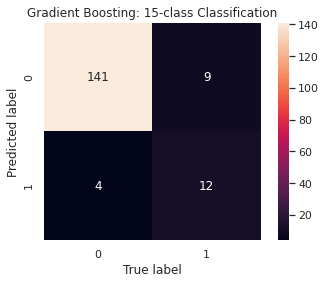

Accuracy:	0.921687
F1-score:	0.802290
Precision:	0.845000
Recall:		0.771921

Classification performance of Tuned Gradient Boosting Classifier:
              precision    recall  f1-score   support

       civil       0.94      0.97      0.96       145
    criminal       0.75      0.57      0.65        21

    accuracy                           0.92       166
   macro avg       0.84      0.77      0.80       166
weighted avg       0.92      0.92      0.92       166



In [61]:
# Plot the confusion matrix for model 7: tuned Gradient Boosting classifier
model7_gbc2 = confusion_matrix(test_label, predicted_categories7_gbc2)
sns.heatmap(model7_gbc2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Gradient Boosting: 15-class Classification")

plt.savefig("GBC_tuned_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories7_gbc2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories7_gbc2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories7_gbc2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories7_gbc2, average='macro'))
print("\nClassification performance of Tuned Gradient Boosting Classifier:\n%s" % classification_report(test_label, predicted_categories7_gbc2))

### Implementing Deep Learning: Neural Networks

In [11]:
import torch
from torchtext.legacy import data #For handling text data
from nltk import word_tokenize # Import the word_tokenize function from NLTK
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim

import time

#### Data Preprocessing

In [47]:
TEXT = data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True) # Create text field for dataset
LABEL = data.LabelField(dtype = torch.float,batch_first=True) # Create label field for dataset

fields = [('text',TEXT),('label', LABEL)]

In [ ]:
# Load dataset from csv file
dataset=data.TabularDataset(path = 'UKSC_training_data_NN_2labels.csv',format = 'csv',fields = fields,skip_header = True)
#print(vars(dataset.examples[0])) # Print first text as an example

In [49]:
#dividing data into training and test sets

import random
RANDOM_SEED = 42 # Set random seed for reproducibility.

# Divide dataset into a training set (80%) and a test set (20%)
training_data, test_data = dataset.split(split_ratio=0.8, random_state = random.seed(RANDOM_SEED))

print("Training samples:",len(training_data))
print("Test samples:",len(test_data))

Training samples: 930
Test samples: 232


In [50]:
#creating vocabulary using training set

TEXT.build_vocab(training_data,min_freq=1) # Build vocabulary from training set. Consider words that occur at least 1 time
LABEL.build_vocab(training_data) # Build vocabulary for labels

print("Size of TEXT vocabulary:",len(TEXT.vocab)) # Number of unique tokens in vocabulary
print("Size of LABEL vocabulary:",len(LABEL.vocab),"\n") # Number of unique labels
print("Most common tokens:",TEXT.vocab.freqs.most_common(10),"\n") # Print the 10 most common tokens in the training set

# Print the index number for the unknown token (<unk>) and the token used for padding (<pad>)
print("Index of unknown word <unk>:",TEXT.vocab.stoi['<unk>'])
print("Index of padding word <pad>:",TEXT.vocab.stoi['<pad>'])
print()
print("Number assigned to label:", LABEL.vocab.stoi) #number assigned to each label


Size of TEXT vocabulary: 43600
Size of LABEL vocabulary: 2 

Most common tokens: [('court', 74965), ('section', 56363), ('would', 52616), ('case', 50195), ('lord', 44759), ('act', 41560), ('para', 40587), ('v', 37104), ('appeal', 35251), ('law', 34747)] 

Index of unknown word <unk>: 0
Index of padding word <pad>: 1

Number assigned to label: defaultdict(None, {'civil': 0, 'criminal': 1})


#### Defining Model Architecture

In [51]:
#defining model architecture 
#create two iterators for training and test data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Set device to GPU if cuda available, else CPU
print("Device:",device)

torch.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32 #set batch size for training #why 32?

# Create data iterator for training and test sets
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text), #telling the BucketIterator the function it should use to group the data
    sort_within_batch=True, #sorts data within each mini batch
    device = device)

Device: cpu


In [52]:
#define multi-class accuracy metric
#accuracy is calculated by performing argmax to get the index of the max.value
#in the prediction for each element, and counting no.of times this equals the actual label
#the values are then averaged across the batch.
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds)) # Round predictions to the closest integer
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [53]:
training_iterator

In [60]:
batch = next(training_iterator.__iter__())
print(batch)
print()

#use batch as wrapper to bundle all attributes to one variable dictionary
print(batch.__dict__.keys())


[torchtext.legacy.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x15947]', '[torch.LongTensor of size 32]')
	[.label]:[torch.FloatTensor of size 32]

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])


In [61]:
#check whether the dataset attribute of "batch" variable == the training_data variable
batch.__dict__['dataset'], training_data, batch.__dict__['dataset']==training_data

(<torchtext.legacy.data.dataset.Dataset at 0x7f89cdfff7f0>,
 True)

In [63]:
training_data[0].__dict__.keys()

dict_keys(['text', 'label'])

In [64]:
training_data[0].__dict__['text'][:5]

['michaelmas', 'term', 'uksc', 'appeal', 'ewca']

### Deploying a Convolutional Neural Network

In [54]:
class LegalAreaCNN(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, 
                                      embedding_dim, 
                                      padding_idx = pad_idx)
        #convolutional layers
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        #fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        #dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):   
        #text = text.permute(1, 0)
        embedded = self.embedding(text)     
        embedded = embedded.unsqueeze(1)       
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]    
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(cat)
    
#code adapted from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [55]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LegalAreaCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)


In [56]:
print(model)
def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\n CNN model trainable parameters:",parameters(model))

LegalAreaCNN(
  (embedding): Embedding(43600, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

 CNN model trainable parameters: 4480601


In [57]:
#identify optimizer and loss criterion
optimizer = optim.Adam(model.parameters()) # Use the Adam optimiser
criterion = nn.BCEWithLogitsLoss() # Use Binary Cross Entropy between the target and the output as the loss function
#criterion = nn.CrossEntropyLoss()

In [58]:
#send model to device
model = model.to(device)
criterion = criterion.to(device)

In [59]:
#defining a training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, _ = batch.text  #unpack the tuple
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label) 
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#defining an evaluation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
         for batch in iterator:
            text, _ = batch.text  #unpack the tuple
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#training and evaluating performance of CNN over 10 epochs
N_EPOCHS = 10 # 10 epochs
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_epoch = 0

#lists to store the loss and accuracy for training and validation for each epoch
epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []

for epoch in range(N_EPOCHS):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    
    #train the model
    train_loss, train_acc = train(model, training_iterator, optimizer, criterion)
    epoch_loss_train.append(train_loss) #append training loss for each epoch
    epoch_accuracy_train.append(train_acc) #append training accuracy of each epoch
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    epoch_loss_valid.append(valid_loss) #append validation loss for each epoch
    epoch_accuracy_valid.append(valid_acc) #append validation accuracy of each epoch
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'CNN2_saved_weights.pt')
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))
    
print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" %
      (best_epoch,best_valid_loss,best_valid_acc))

Epoch   0: Train loss: 0.872 | Train acuracy: 0.5177 | Validation loss: 0.510 | Validation acuracy: 0.6719 - 669.27 s
Epoch   1: Train loss: 0.494 | Train acuracy: 0.7594 | Validation loss: 0.340 | Validation acuracy: 0.9727 - 672.11 s
Epoch   2: Train loss: 0.378 | Train acuracy: 0.8438 | Validation loss: 0.260 | Validation acuracy: 0.9492 - 721.79 s
Epoch   3: Train loss: 0.275 | Train acuracy: 0.9031 | Validation loss: 0.192 | Validation acuracy: 0.9648 - 659.35 s
Epoch   4: Train loss: 0.223 | Train acuracy: 0.9271 | Validation loss: 0.165 | Validation acuracy: 0.9531 - 662.64 s
Epoch   5: Train loss: 0.172 | Train acuracy: 0.9469 | Validation loss: 0.156 | Validation acuracy: 0.9531 - 645.15 s
Epoch   6: Train loss: 0.131 | Train acuracy: 0.9573 | Validation loss: 0.120 | Validation acuracy: 0.9727 - 654.55 s
Epoch   7: Train loss: 0.123 | Train acuracy: 0.9573 | Validation loss: 0.095 | Validation acuracy: 0.9766 - 646.27 s
Epoch   8: Train loss: 0.126 | Train acuracy: 0.9646 | V

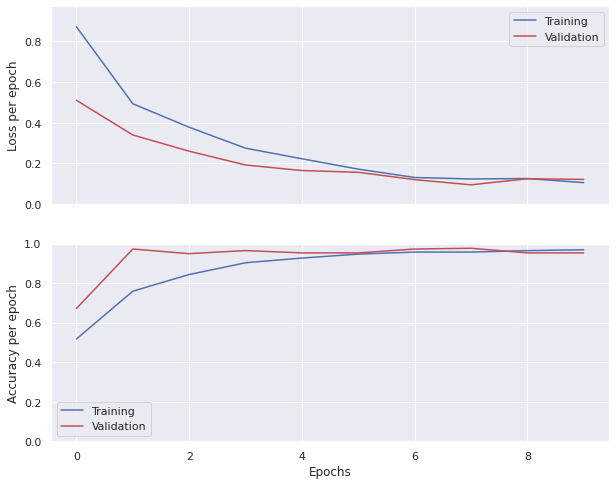

In [60]:
#one plot showing the training loss and validation loss
#another plot showing the training accuracy and validation accuracy

import numpy as np
import matplotlib.pyplot as plt

eps = np.arange(N_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), sharex=True)

#ax1.set_ylim([0, 1])
#to make the loss plot more visible
ax1.set_ylim([0, max(max(epoch_loss_train), max(epoch_loss_valid)) + 0.1])

ax1.plot(epoch_loss_train,'b')
ax1.plot(epoch_loss_valid,'r')
ax1.set_ylabel("Loss per epoch")
ax1.legend(["Training","Validation"])

ax2.set_ylim([0, 1])
ax2.plot(epoch_accuracy_train,'b')
ax2.plot(epoch_accuracy_valid,'r')
ax2.set_ylabel("Accuracy per epoch")
ax2.set_xlabel("Epochs");
ax2.legend(["Training","Validation"])

plt.savefig("Epoch loss_BinaryCNN")
plt.show()

In [61]:
max_words = 0
for sentence in train_text :
    max_words = max(len(sentence.split()), max_words )
print("There are a maximum of", max_words, "words in each training text")


There are a maximum of 33654 words in each training text


In [62]:
model.load_state_dict(torch.load('CNN2_saved_weights.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.095 | Test Acc: 97.66%


In [63]:
def LegalAreaCNN_predict(model, sentence, min_len = max_words):
    model.eval()
    #preprocess 
    tokenised = [token for token in word_tokenize(sentence)] # Tokenise text
    indexed = [TEXT.vocab.stoi[token] for token in tokenised]
    tensor = torch.LongTensor(indexed).to(device) # Convert to PyTorch tensor
    
    tensor = tensor.unsqueeze(0) # Reshape in form of batch,number of words
    prediction = model(tensor)
    prediction = prediction.argmax(dim = 1)
    return int(round(prediction.item()))

#code adapted from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [64]:
label_names = {1:"criminal", 0: "civil"}
#Number assigned to label: defaultdict(None, {'civil': 0, 'criminal': 1})

predict_CNN2 = []

for i in test_text:
    predict_label = label_names[LegalAreaCNN_predict(model, i)]
    predict_CNN2.append(predict_label)
    
print("Predicted Label:",predict_CNN2[0:10])
print("Ground Truth Label:",test_label[0:10])

Predicted Label: ['civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil', 'civil']
Ground Truth Label: ['criminal', 'civil', 'civil', 'civil', 'civil', 'civil', 'criminal', 'civil', 'civil', 'civil']


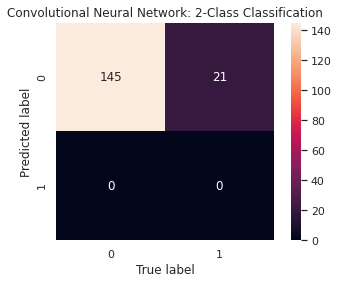

Accuracy:	0.873494
F1-score:	0.466238
Precision:	0.436747
Recall:		0.500000

Classification performance of CNN:
              precision    recall  f1-score   support

       civil       0.87      1.00      0.93       145
    criminal       0.00      0.00      0.00        21

    accuracy                           0.87       166
   macro avg       0.44      0.50      0.47       166
weighted avg       0.76      0.87      0.81       166



/apps/jupyterhub/COMP42415/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/jupyterhub/COMP42415/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
#plot the confusion matrix: CNN
mat_cnn = confusion_matrix(test_label, predict_CNN2)
sns.heatmap(mat_cnn.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Convolutional Neural Network: 2-Class Classification")
plt.savefig("CNN_70000_2_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predict_CNN2))
print("F1-score:\t%f" % f1_score(test_label, predict_CNN2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predict_CNN2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predict_CNN2, average='macro'))
print("\nClassification performance of CNN:\n%s" % classification_report(test_label, predict_CNN2))